# SCS 3547: Intelligent Agents
> Term Project - Genetic Algorithms for Portfolio Strategy Optimization

### Name & student number:

<pre> Sigao Li </pre>

<pre> X503624 </pre>

## Import Required Libraries

In [1]:
import os
import logging
import requests
import random
import math
import pandas as pd
import numpy as np
from ib_insync import IB, Stock, util
from deap import base, creator, tools, algorithms
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import torch
import time
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import multiprocessing
from multiprocessing import Pool
from functools import partial
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt
from sklearn.preprocessing import RobustScaler
import talib

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


In [2]:
# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s :: %(levelname)s :: %(message)s')

## Get Data from IBKR

In [3]:
class AutomatedTradingAgent:
    def __init__(self, host='127.0.0.1', port=7497):
        self.host = host
        self.port = port
        self.clientId = random.randint(0, 10000)
        self.ib = None

        self.initialize_connection()

    def initialize_connection(self):
        """Establishes connection to the Interactive Brokers API."""
        util.startLoop()  # This is necessary for the asynchronous nature of the networking code
        self.ib = IB()
        try:
            self.ib.connect(self.host, self.port, clientId=self.clientId)
            logging.info("Connection to IB API established.")
        except Exception as e:
            logging.error(f"Failed to connect to IB API: {e}", exc_info=True)
            self.ib = None

    def calculate_indicators(self, df):
        # Ensure all necessary columns are floats for TA-Lib compatibility
        for column in ['open', 'high', 'low', 'close', 'volume', 'barCount']:
            df[column] = df[column].astype(float)

        # Exponential Moving Average (EMA)
        df['EMA'] = talib.EMA(df['close'], timeperiod=14)

        # Relative Strength Index (RSI)
        df['RSI'] = talib.RSI(df['close'], timeperiod=14)

        # Bollinger Bands Width
        upperband, middleband, lowerband = talib.BBANDS(df['close'], timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)
        df['BB_width'] = (upperband - lowerband) / middleband

        # Average True Range Percentage (ATRP)
        atr = talib.ATR(df['high'], df['low'], df['close'], timeperiod=14)
        df['ATRP'] = atr / df['close'] * 100

        # Money Flow Index (MFI)
        df['MFI'] = talib.MFI(df['high'], df['low'], df['close'], df['volume'], timeperiod=14)

        # VWAP - Custom calculation
        vwap = (df['volume'] * (df['high'] + df['low'] + df['close']) / 3).cumsum() / df['volume'].cumsum()
        df['VWAP'] = vwap

        # Volume-Price Trend (VPT) - Custom calculation
        df['VPT'] = ((df['close'].diff() / df['close'].shift(1)) * df['volume']).cumsum()

        # Custom Transaction Momentum Index (TMI)
        tmi_basic = (df['barCount'] - df['barCount'].rolling(window=14).mean()) / df['barCount'].rolling(window=14).std()
        df['TMI'] = tmi_basic * 100 - df['AVG.INTWO'] / 100

        return df

    def get_historical_data(self, symbol, currency, corra_data):
        """Fetches 2 years of daily historical data for the given symbol and merges it with AVG.INTWO data."""
        if not self.ib:
            logging.error("Not connected to IB API.")
            return pd.DataFrame()

        try:
            contract = Stock(symbol, 'SMART', currency)
            self.ib.qualifyContracts(contract)

            duration = "2 Y"
            bars = self.ib.reqHistoricalData(
                contract,
                endDateTime='',
                durationStr=duration,
                barSizeSetting='1 day',
                whatToShow='TRADES',
                useRTH=True,
                formatDate=1
            )

            # Convert to DataFrame and perform preprocessing
            df = util.df(bars)
            df['date'] = pd.to_datetime(df['date'])  # Ensure datetime format
            df['date'] = df['date'].dt.date
            df.set_index('date', inplace=True)  # Set datetime as index
            df.sort_index(inplace=True)  # Sort data by datetime
            df['symbol'] = symbol  # Add symbol column

            # Merge with CORRA data
            df = df.merge(corra_data, left_index=True, right_index=True, how='left')

            # Fill null values in AVG.INTWO with the value of the previous day using ffill() as recommended
            df['AVG.INTWO'] = df['AVG.INTWO'].ffill()

            # Calculate technical indicators
            df = self.calculate_indicators(df)

            logging.info(f"Retrieved and processed historical data for {symbol}.")
            return df
        except Exception as e:
            logging.error(f"Failed to fetch and process historical data for {symbol}: {e}", exc_info=True)
            return pd.DataFrame()

In [4]:
if __name__ == "__main__":
    logging.basicConfig(level=logging.INFO)  # Configure logging
    currency = "CAD"  # Assuming all stocks are in the same currency for simplicity

    # Create the folder for storing datasets
    folder_name = "Stock_dataset"
    os.makedirs(folder_name, exist_ok=True)

    # Load stock symbols from an Excel file (make sure you have this file available)
    stock_symbols = pd.read_excel("TSX_60_Index.xlsx", usecols=["Symbol"], na_filter=False).squeeze().tolist()

    # Read CORRA data from an Excel file (make sure you have this file available)
    corra_data = pd.read_excel("CORRA.xlsx", usecols=["date", "AVG.INTWO"])
    corra_data['date'] = pd.to_datetime(corra_data['date'])  # Ensure datetime format
    corra_data['date'] = corra_data['date'].dt.date
    corra_data.set_index('date', inplace=True)  # Set datetime as index

    # Instantiate the AutomatedTradingAgent class
    tradingAgent = AutomatedTradingAgent()

    # Fetch, merge, and save historical data for each symbol
    for symbol in stock_symbols:
        df = tradingAgent.get_historical_data(symbol, currency, corra_data)
        file_path = os.path.join(folder_name, f"{symbol}_data.xlsx")
        df.to_excel(file_path)
        logging.info(f"Data for {symbol} saved to {file_path}.")

2024-03-26 22:19:55,421 :: INFO :: Connecting to 127.0.0.1:7497 with clientId 1058...
2024-03-26 22:19:55,422 :: INFO :: Connected
2024-03-26 22:19:55,426 :: INFO :: Logged on to server version 176
2024-03-26 22:19:55,427 :: INFO :: Warning 2104, reqId -1: Market data farm connection is OK:usfarm.nj
2024-03-26 22:19:55,427 :: INFO :: Warning 2104, reqId -1: Market data farm connection is OK:cashfarm
2024-03-26 22:19:55,428 :: INFO :: Warning 2104, reqId -1: Market data farm connection is OK:cafarm
2024-03-26 22:19:55,428 :: INFO :: Warning 2104, reqId -1: Market data farm connection is OK:usfarm
2024-03-26 22:19:55,428 :: INFO :: Warning 2106, reqId -1: HMDS data farm connection is OK:euhmds
2024-03-26 22:19:55,429 :: INFO :: Warning 2106, reqId -1: HMDS data farm connection is OK:cashhmds
2024-03-26 22:19:55,429 :: INFO :: Warning 2106, reqId -1: HMDS data farm connection is OK:fundfarm
2024-03-26 22:19:55,429 :: INFO :: Warning 2106, reqId -1: HMDS data farm connection is OK:ushmds
2

2024-03-26 22:20:06,222 :: INFO :: Data for MRU saved to Stock_dataset\MRU_data.xlsx.
2024-03-26 22:20:06,328 :: INFO :: Retrieved and processed historical data for NA.
2024-03-26 22:20:06,536 :: INFO :: Data for NA saved to Stock_dataset\NA_data.xlsx.
2024-03-26 22:20:06,643 :: INFO :: Retrieved and processed historical data for NTR.
2024-03-26 22:20:06,861 :: INFO :: Data for NTR saved to Stock_dataset\NTR_data.xlsx.
2024-03-26 22:20:06,979 :: INFO :: Retrieved and processed historical data for OTEX.
2024-03-26 22:20:07,182 :: INFO :: Data for OTEX saved to Stock_dataset\OTEX_data.xlsx.
2024-03-26 22:20:07,298 :: INFO :: Retrieved and processed historical data for POW.
2024-03-26 22:20:07,490 :: INFO :: Data for POW saved to Stock_dataset\POW_data.xlsx.
2024-03-26 22:20:07,748 :: INFO :: Retrieved and processed historical data for PPL.
2024-03-26 22:20:07,957 :: INFO :: Data for PPL saved to Stock_dataset\PPL_data.xlsx.
2024-03-26 22:20:08,064 :: INFO :: Retrieved and processed histo

# Visualize Stock Data

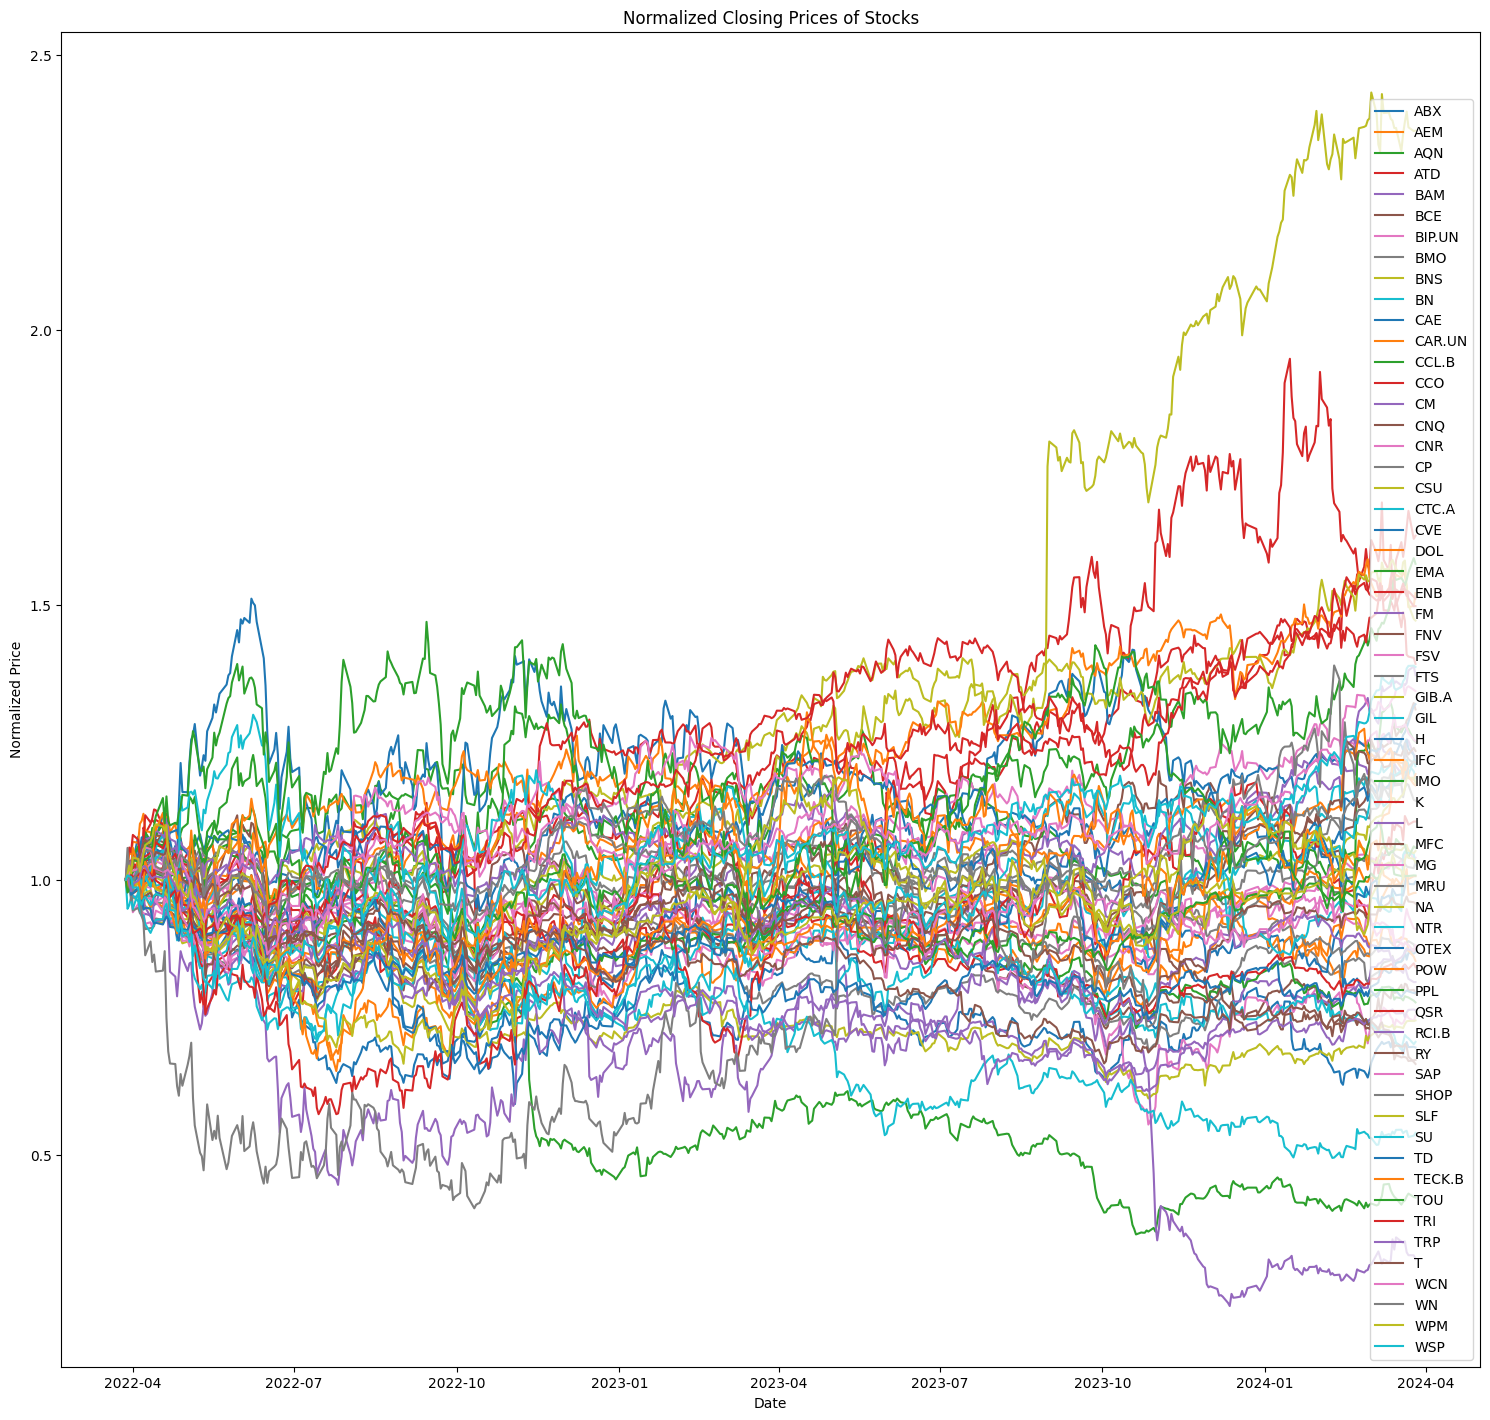

In [5]:
def plot_normalized_closing_prices(folder_name):
    plt.figure(figsize=(15, 15))  # Set the figure size for better visibility

    # List all Excel files in the specified folder
    stock_files = [f for f in os.listdir(folder_name) if f.endswith('_data.xlsx')]

    for file in stock_files:
        symbol = file.split('_')[0]  # Extract the stock symbol from the filename
        file_path = os.path.join(folder_name, file)
        
        # Load the data
        df = pd.read_excel(file_path, index_col='date')
        
        # Ensure 'date' is a datetime type (if not already)
        df.index = pd.to_datetime(df.index)
        
        # Normalize the closing prices to the first day
        normalized_close = df['close'] / df['close'].iloc[0]
        
        # Plotting
        plt.plot(normalized_close.index, normalized_close, label=symbol)

    plt.title("Normalized Closing Prices of Stocks")
    plt.xlabel("Date")
    plt.ylabel("Normalized Price")
    plt.legend()
    plt.tight_layout()

    # Display the plot
    plt.show()

# Example usage
folder_name = "Stock_dataset"
plot_normalized_closing_prices(folder_name)

Select the two stocks with the largest increase, two stocks with the largest decrease, and two stocks with the smallest change as samples.

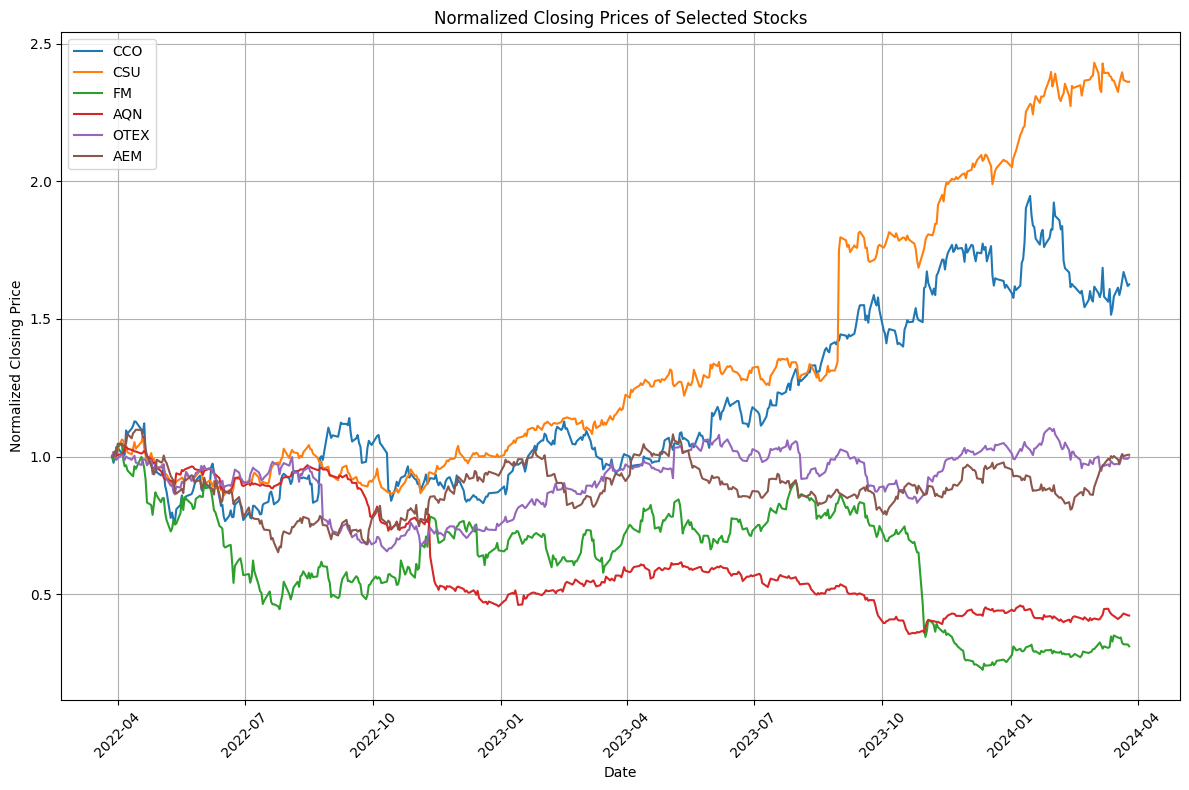

In [6]:
def find_stocks_and_save(folder_name):
    changes = {}  # Dictionary to hold the final day's change for each stock
    normalized_prices = {}  # To store normalized prices for visualization
    all_dates = []  # To store all 80% dates for calculating the median

    # List all Excel files in the specified folder
    stock_files = [f for f in os.listdir(folder_name) if f.endswith('_data.xlsx')]

    for file in stock_files:
        symbol = file.split('_')[0]  # Extract the stock symbol from the filename
        file_path = os.path.join(folder_name, file)
        
        # Load the data
        df = pd.read_excel(file_path, index_col='date')
        
        # Normalize the closing prices to the first day
        normalized_close = df['close'] / df['close'].iloc[0]
        
        # Store the normalized prices for later plotting
        normalized_prices[symbol] = normalized_close
        
        # Calculate the change from the first to the last day
        change = normalized_close.iloc[-1] - 1
        changes[symbol] = change

        # Calculate and store the 80% date for each stock
        num_dates = len(df)
        eighty_percent_mark = int(num_dates * 0.8) - 1
        eighty_percent_date = df.index[eighty_percent_mark]
        all_dates.append(eighty_percent_date)

    # Determine the median 80% date across all stocks
    all_dates.sort()
    median_80_percent_date = all_dates[len(all_dates) // 2]

    # Sort changes to find the stocks
    sorted_changes = sorted(changes.items(), key=lambda x: x[1])
    largest_decreases = sorted_changes[:2]
    least_changes = sorted(sorted_changes, key=lambda x: abs(x[1]))[:2]
    largest_increases = sorted_changes[-2:]

    # Prepare data for Excel
    rep_stocks_data = {
        "Symbol": [item[0] for item in largest_increases + largest_decreases + least_changes],
        "Category": ["Largest Increase"]*2 + ["Largest Decrease"]*2 + ["Least Change"]*2
    }
    rep_stocks = pd.DataFrame(rep_stocks_data)

    # Save to Excel
    rep_stocks.to_excel("Rep_Stocks.xlsx", index=False)

    # Visualization
    plt.figure(figsize=(12, 8))
    for symbol, _ in largest_increases + largest_decreases + least_changes:
        plt.plot(normalized_prices[symbol].index, normalized_prices[symbol], label=symbol)

    # The axvline for the 80% date has been removed from this version of the code

    plt.title("Normalized Closing Prices of Selected Stocks")
    plt.xlabel("Date")
    plt.ylabel("Normalized Closing Price")
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Example usage
folder_name = "Stock_dataset"
find_stocks_and_save(folder_name)

## Clean the Data and Split It for the Model

In [7]:
def create_sequences(data, sequence_length):
    sequences = []
    targets = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i+sequence_length])
        targets.append(data[i+sequence_length])
    return np.array(sequences), np.array(targets)

def process_stock_data(file_path, sequence_length=20):
    # Read the data
    df = pd.read_excel(file_path, index_col='date')

    # Drop any rows with null values
    df.dropna(inplace=True)

    # Explicitly cast features to float type to avoid FutureWarning
    features = ['open', 'high', 'low', 'close', 'volume', 'average', 'barCount', 'AVG.INTWO', 'EMA','RSI','BB_width','ATRP','MFI','VWAP','VPT','TMI']
    df[features] = df[features].astype(float)
    
    # Split the data into training and testing datasets
    split_idx = int(len(df) * 0.8)
    df_train = df.iloc[:split_idx].copy()
    df_test = df.iloc[split_idx:].copy()

    # Print the number of rows in the training and testing data
    print(f"Training data rows: {len(df_train)}")
    print(f"Testing data rows: {len(df_test)}")

    # Normalize features using Z-score Scaling for training data
    scaler = StandardScaler()
    df_train[features] = scaler.fit_transform(df_train[features])

    # Apply the same transformation to the test data
    df_test[features] = scaler.transform(df_test[features])

    # Create sequences and corresponding targets for training data
    X_train, y_train = create_sequences(df_train[features].values, sequence_length)

    # Do the same for test data
    X_test, y_test = create_sequences(df_test[features].values, sequence_length)

    # Print the number of sequences created for training and testing data
    print(f"Training sequences: {len(X_train)}")
    print(f"Testing sequences: {len(X_test)}")
    
    scaler_params = {'mean': scaler.mean_, 'scale': scaler.scale_}
    
    return X_train, y_train, X_test, y_test, scaler_params

def process_selected_stocks(folder_path, rep_stocks_path, sequence_length=20):
    # Read the symbols from "Rep_Stocks.xlsx"
    rep_stocks = pd.read_excel(rep_stocks_path)
    symbols = rep_stocks['Symbol'].tolist()
    
    # Ensure the output folders exist
    train_folder = os.path.join(folder_path, 'Train')
    test_folder = os.path.join(folder_path, 'Test')
    os.makedirs(train_folder, exist_ok=True)
    os.makedirs(test_folder, exist_ok=True)

    # Process each selected stock
    for symbol in symbols:
        file_name = f"{symbol}_data.xlsx"
        file_path = os.path.join(folder_path, file_name)
        if os.path.exists(file_path):
            print(f"Processing {symbol}...")
            X_train, y_train, X_test, y_test, scaler_params = process_stock_data(file_path, sequence_length)
            
            # Save the processed data
            np.savez_compressed(os.path.join(train_folder, f"{symbol}_train.npz"), X=X_train, y=y_train)
            np.savez_compressed(os.path.join(test_folder, f"{symbol}_test.npz"), X=X_test, y=y_test)
            np.savez_compressed(os.path.join(train_folder, f"{symbol}_scaler_params.npz"), **scaler_params)
            
            print(f"{symbol} processed and saved.")
        else:
            print(f"Data file for {symbol} not found.")

# Specify the path to your "Stock_dataset" folder
folder_path = "Stock_dataset"
rep_stocks_path = "Rep_Stocks.xlsx"  # Path to "Rep_Stocks.xlsx"
process_selected_stocks(folder_path, rep_stocks_path)
print("All stocks processed.")

Processing CCO...
Training data rows: 386
Testing data rows: 97
Training sequences: 366
Testing sequences: 77
CCO processed and saved.
Processing CSU...
Training data rows: 386
Testing data rows: 97
Training sequences: 366
Testing sequences: 77
CSU processed and saved.
Processing FM...
Training data rows: 386
Testing data rows: 97
Training sequences: 366
Testing sequences: 77
FM processed and saved.
Processing AQN...
Training data rows: 386
Testing data rows: 97
Training sequences: 366
Testing sequences: 77
AQN processed and saved.
Processing OTEX...
Training data rows: 386
Testing data rows: 97
Training sequences: 366
Testing sequences: 77
OTEX processed and saved.
Processing AEM...
Training data rows: 386
Testing data rows: 97
Training sequences: 366
Testing sequences: 77
AEM processed and saved.
All stocks processed.


# Optimizing Hyperparameters of Transformers Using Genetic Algorithms

In [ ]:
# Define the Transformer model (including PositionalEncoding)
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout / 100.0)  # Adjusted for integer representation

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(np.log(10000.0) / d_model))
        pe = torch.zeros(max_len, d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        if d_model % 2 == 1:
            # Adjust for an odd number of d_model
            div_term_extended = torch.exp(torch.arange(0, d_model + 1, 2) * -(np.log(10000.0) / d_model))
            pe[:, 1::2] = torch.cos(position * div_term_extended[:-1])
        else:
            pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

class TimeSeriesTransformer(nn.Module):
    def __init__(self, feature_size, num_layers, num_heads, dropout_rate=0.1):
        super(TimeSeriesTransformer, self).__init__()
        self.feature_size = feature_size
        self.num_layers = num_layers 
        
        encoder_layers = nn.TransformerEncoderLayer(d_model=feature_size, nhead=num_heads, dropout=dropout_rate / 100.0, batch_first=True)  # Adjusted for integer representation
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=num_layers)
        
        self.pos_encoder = PositionalEncoding(feature_size, dropout_rate)
        self.decoder = nn.Linear(feature_size, feature_size)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src):
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src)
        output = output[:, -1, :]
        output = self.decoder(output)
        return output

def mutCustom(individual, int_ranges, indpb):
    for i in range(len(individual)):
        if random.random() < indpb:
            individual[i] = random.choice(int_ranges[i])
    return individual,

# Modify the train_model function for dynamic hyperparameters and GPU utilization
def train_model(train_loader, num_layers, num_heads, lr, dropout_rate, batch_size, num_epochs, symbol):
    feature_size = 16  # Assuming feature size is fixed, as per your model's architecture
    if feature_size % num_heads != 0:
        raise ValueError(f"feature_size ({feature_size}) must be divisible by num_heads ({num_heads})")
    
    # Scale lr back for actual use
    lr = lr / 1000.0  # Adjusted back to its original scale
    
    print(f"Training {symbol} with hyperparameters: Layers={num_layers}, Heads={num_heads}, LR={lr}, Dropout={dropout_rate}%, Batch={batch_size}, Epochs={num_epochs}")
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    model = TimeSeriesTransformer(feature_size, num_layers, num_heads, dropout_rate).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            output = model(X_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        scheduler.step()
    
    return model

# Modify the evaluate_model function for GPU utilization
def evaluate_model(model, test_loader, symbol, train_path):
    model.eval()
    actuals = []
    predictions = []
    scaler_params = np.load(os.path.join(train_path, f'{symbol}_scaler_params.npz'))
    mean_val = scaler_params['mean'][3]  # Assuming the target feature is at index 3
    scale_val = scaler_params['scale'][3]
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            output = model(X_batch).detach().cpu().numpy()
            predictions.extend(output[:, 3])  # Assuming the target prediction is at index 3
            actuals.extend(y_batch.cpu().numpy()[:, 3])
    actuals = np.array(actuals) * scale_val + mean_val
    predictions = np.array(predictions) * scale_val + mean_val

    directional_accuracy = calculate_directional_accuracy(actuals, predictions)
    theils_u_value = calculate_theils_u(actuals, predictions)
    
    return directional_accuracy, -theils_u_value

def load_data(stock_symbol, train_path, test_path):
    train_data = np.load(os.path.join(train_path, f'{stock_symbol}_train.npz'))
    test_data = np.load(os.path.join(test_path, f'{stock_symbol}_test.npz'))
    X_train, y_train = train_data['X'], train_data['y']
    X_test, y_test = test_data['X'], test_data['y']
    return X_train, y_train, X_test, y_test

def prepare_dataloaders(X_train, y_train, X_test, y_test, batch_size=32):
    X_train_tensor = torch.Tensor(X_train)
    y_train_tensor = torch.Tensor(y_train).view(-1, 16)  # Assuming output size is 16
    X_test_tensor = torch.Tensor(X_test)
    y_test_tensor = torch.Tensor(y_test).view(-1, 16)
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader

def calculate_directional_accuracy(actuals, predictions):
    correct_directions = np.sum(np.sign(predictions[1:] - actuals[:-1]) == np.sign(actuals[1:] - actuals[:-1]))
    total_predictions = len(actuals) - 1
    directional_accuracy = correct_directions / total_predictions
    return directional_accuracy

def calculate_theils_u(actuals, predictions):
    numerator = np.sum((actuals - predictions) ** 2)
    denominator = np.sum(actuals ** 2) + np.sum(predictions ** 2)
    return np.sqrt(numerator / denominator)

# Function to get stock symbols from the training data folder
def get_stock_symbols(train_path):
    files = os.listdir(train_path)
    symbols = set(file.split('_')[0] for file in files if file.endswith('_train.npz'))
    return list(symbols)

# Evaluation function utilizing the model training and evaluation
def evaluate(individual, symbol, train_path, test_path):
    # Unpack the individual's parameters
    num_layers, num_heads, lr, dropout_rate, batch_size, num_epochs = individual
    
    X_train, y_train, X_test, y_test = load_data(symbol, train_path, test_path)
    train_loader, test_loader = prepare_dataloaders(X_train, y_train, X_test, y_test, batch_size=batch_size)
    model = train_model(train_loader, num_layers, num_heads, lr, dropout_rate, batch_size, num_epochs, symbol)
    directional_accuracy, negative_theils_u = evaluate_model(model, test_loader, symbol, train_path)
    
    # Here we convert the negative_theils_u back to its original positive form (since it was returned as negative)
    theils_u = -negative_theils_u
    
    # Composite fitness measure that incorporates both metrics
    # Subtract a scaled Theil's U from the directional accuracy to differentiate models with similar accuracies
    # Adjust the scaling factor as necessary to ensure a balance between the metrics
    composite_fitness = directional_accuracy - (0.05 * theils_u)
    
    return composite_fitness,

def setup_ga_toolbox(evaluate, symbol, train_path, test_path):
    creator.create("FitnessMax", base.Fitness, weights=(1.0,))  # Adjusted for single objective
    creator.create("Individual", list, fitness=creator.FitnessMax)

    toolbox = base.Toolbox()
    
    # Register attributes (genome) with predefined values
    toolbox.register("attr_num_layers", random.choice, [2, 4, 8])
    toolbox.register("attr_num_heads", random.choice, [2, 4, 8])
    toolbox.register("attr_lr", random.choice, [1, 5, 10])
    toolbox.register("attr_dropout", random.choice, [30, 40, 50])
    toolbox.register("attr_batch_size", random.choice, [16, 32, 64])
    toolbox.register("attr_epochs", random.choice, [30, 40, 50])

    # Initialize the individual and population
    toolbox.register("individual", tools.initCycle, creator.Individual,
                     (toolbox.attr_num_layers, toolbox.attr_num_heads, toolbox.attr_lr,
                      toolbox.attr_dropout, toolbox.attr_batch_size, toolbox.attr_epochs), n=1)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    # Register the evaluation function
    toolbox.register("evaluate", evaluate, symbol=symbol, train_path=train_path, test_path=test_path)

    # Register the genetic operators
    toolbox.register("mate", tools.cxUniform, indpb=0.5)
    toolbox.register("mutate", mutCustom, int_ranges={
        0: [2, 4, 8],  # num_layers
        1: [2, 4, 8],  # num_heads
        2: [1, 5, 10],  # lr
        3: [30, 40, 50],  # dropout
        4: [16, 32, 64],  # batch_size
        5: [30, 40, 50],  # epochs
    }, indpb=0.3)
    toolbox.register("select", tools.selRoulette)

    return toolbox

def print_population_stats(symbol, generation, population, best_fitness, worst_fitness):
    fits = [ind.fitness.values[0] for ind in population]

    max_fit = max(fits)
    min_fit = min(fits)
    mean = sum(fits) / len(fits)
    std = (sum((fit - mean) ** 2 for fit in fits) / len(fits)) ** 0.5
    
    print(f"Stock: {symbol}, Gen: {generation}, Max Fit: {max_fit}, Min Fit: {min_fit}, Avg Fit: {mean}, Std: {std}")
    
    return max_fit, min_fit

def main(toolbox, symbol, train_path, test_path):
    random.seed(64)
    pop = toolbox.population(n=25)
    
    if not pop:
        print("Failed to initialize population.")
        return
    
    print(f"\nInitialized population for {symbol} with {len(pop)} individuals.")
    CXPB, MUTPB, NGEN, EARLY_STOPPING_ROUNDS = 0.7, 0.3, 30, 5
    best_fitness = float("-inf")
    worst_fitness = float("inf")
    rounds_without_improvement = 0

    start_time = time.time()  # Start timing

    with Pool() as pool:
        toolbox.register("map", pool.map)

        # Evaluate the entire population
        fitnesses = list(map(toolbox.evaluate, pop))
        for ind, fit in zip(pop, fitnesses):
            ind.fitness.values = fit

        # Initialize best and worst individuals after evaluating the initial population
        best_individual = max(pop, key=lambda ind: ind.fitness.values[0])
        worst_individual = min(pop, key=lambda ind: ind.fitness.values[0])
        best_fitness = best_individual.fitness.values[0]
        worst_fitness = worst_individual.fitness.values[0]

        # Initial population statistics

        print_population_stats(symbol, "Initial", pop, best_fitness, worst_fitness)

        for gen in range(NGEN):
            print(f"\n=== Generation {gen} for stock: {symbol} ===")

            offspring = list(map(toolbox.clone, toolbox.select(pop, len(pop))))
            for child1, child2 in zip(offspring[::2], offspring[1::2]):
                if random.random() < CXPB:
                    toolbox.mate(child1, child2)
                    del child1.fitness.values, child2.fitness.values
            for mutant in offspring:
                if random.random() < MUTPB:
                    toolbox.mutate(mutant)
                    del mutant.fitness.values

            invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
            fitnesses = list(map(toolbox.evaluate, invalid_ind))
            for ind, fit in zip(invalid_ind, fitnesses):
                ind.fitness.values = fit

            pop[:] = offspring

            max_fit, min_fit = print_population_stats(symbol, gen, pop, best_fitness, worst_fitness)
            if max_fit > best_fitness:
                best_fitness = max_fit
                best_individual = max(pop, key=lambda ind: ind.fitness.values[0])
                rounds_without_improvement = 0
            else:
                rounds_without_improvement += 1

            if min_fit < worst_fitness:
                worst_fitness = min_fit
                worst_individual = min(pop, key=lambda ind: ind.fitness.values[0])

            if rounds_without_improvement >= EARLY_STOPPING_ROUNDS:
                print("Early stopping due to lack of improvement.")
                break

    elapsed_time = time.time() - start_time
    print(f"\n-- End of optimization for {symbol} --\n")
    print(f"Optimization took {elapsed_time:.2f} seconds.")

    if best_individual is not None and worst_individual is not None:
        print(f"Best Hyperparameters for {symbol}: {best_individual}, Fitness (Dir. Acc., theils_u): {best_individual.fitness.values}")
        print(f"Worst Hyperparameters for {symbol}: {worst_individual}, Fitness (Dir. Acc., theils_u): {worst_individual.fitness.values}")
    else:
        print("Best or worst individual not found.")

    return {
        'best_ind': best_individual if best_individual is not None else 'Not found',
        'worst_ind': worst_individual if worst_individual is not None else 'Not found',
        'best_fitness': best_fitness,
        'worst_fitness': worst_fitness,
        'elapsed_time': elapsed_time
    }

def save_model(model, directory, symbol, descriptor):
    if not os.path.isdir(directory):
        os.makedirs(directory, exist_ok=True)
    model_path = os.path.join(directory, f"{symbol}_{descriptor}.pth")
    torch.save(model.state_dict(), model_path)
    print(f"Model saved to {model_path}")

if __name__ == "__main__":
    train_path = 'Stock_dataset/Train'
    test_path = 'Stock_dataset/Test'
    models_dir = 'Transformers_models'
    stock_symbols = get_stock_symbols(train_path)

    results_list = []

    for symbol in stock_symbols:
        toolbox = setup_ga_toolbox(evaluate, symbol, train_path, test_path)
        results = main(toolbox, symbol, train_path, test_path)
        
        # Prepare data loaders for the best and worst models
        X_train, y_train, X_test, y_test = load_data(symbol, train_path, test_path)
        train_loader_best, test_loader_best = prepare_dataloaders(X_train, y_train, X_test, y_test, batch_size=results['best_ind'][4])
        train_loader_worst, test_loader_worst = prepare_dataloaders(X_train, y_train, X_test, y_test, batch_size=results['worst_ind'][4])

        # Train and save the best model
        best_model = train_model(train_loader_best, *results['best_ind'], symbol)
        best_model_dir = os.path.join(models_dir, "Best")
        save_model(best_model, best_model_dir, symbol, "best_model")
        
        # Train and save the worst model
        worst_model = train_model(train_loader_worst, *results['worst_ind'], symbol)
        worst_model_dir = os.path.join(models_dir, "Worst")
        save_model(worst_model, worst_model_dir, symbol, "worst_model")

        # Collect results data
        new_row = {
            'Symbol': symbol,
            'Best Fitness': results['best_fitness'],
            'Worst Fitness': results['worst_fitness'],
            **{f'best_{k}': v for k, v in zip(['num_layers', 'num_heads', 'lr', 'dropout', 'batch_size', 'epochs'], results['best_ind'])},
            **{f'worst_{k}': v for k, v in zip(['num_layers', 'num_heads', 'lr', 'dropout', 'batch_size', 'epochs'], results['worst_ind'])}
        }
        results_list.append(new_row)

    # Convert results to DataFrame and save to Excel
    TSX_60_Index = pd.DataFrame(results_list)
    excel_file_path = 'TSX_60_Index_Optimization_Results.xlsx'
    TSX_60_Index.to_excel(excel_file_path, index=False, engine='openpyxl')

    print()
    print(f"Optimization complete and results saved to {excel_file_path}.")


Initialized population for FM with 25 individuals.
Training FM with hyperparameters: Layers=4, Heads=2, LR=0.01, Dropout=50%, Batch=32, Epochs=50


C:\Users\Sigao Li\.conda\envs\py310\lib\site-packages\transformers\utils\generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
C:\Users\Sigao Li\.conda\envs\py310\lib\site-packages\torch\nn\functional.py:5476: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)


Training FM with hyperparameters: Layers=8, Heads=2, LR=0.001, Dropout=40%, Batch=64, Epochs=50
Training FM with hyperparameters: Layers=2, Heads=8, LR=0.01, Dropout=30%, Batch=16, Epochs=40
Training FM with hyperparameters: Layers=4, Heads=2, LR=0.01, Dropout=30%, Batch=16, Epochs=40
Training FM with hyperparameters: Layers=8, Heads=2, LR=0.001, Dropout=30%, Batch=16, Epochs=50
Training FM with hyperparameters: Layers=2, Heads=8, LR=0.005, Dropout=30%, Batch=64, Epochs=30
Training FM with hyperparameters: Layers=2, Heads=2, LR=0.005, Dropout=40%, Batch=16, Epochs=40
Training FM with hyperparameters: Layers=8, Heads=2, LR=0.01, Dropout=40%, Batch=32, Epochs=50
Training FM with hyperparameters: Layers=4, Heads=8, LR=0.005, Dropout=50%, Batch=32, Epochs=50
Training FM with hyperparameters: Layers=2, Heads=2, LR=0.001, Dropout=30%, Batch=32, Epochs=30
Training FM with hyperparameters: Layers=2, Heads=2, LR=0.001, Dropout=50%, Batch=32, Epochs=30
Training FM with hyperparameters: Layers=8,

Training FM with hyperparameters: Layers=2, Heads=2, LR=0.001, Dropout=40%, Batch=32, Epochs=40
Training FM with hyperparameters: Layers=2, Heads=8, LR=0.01, Dropout=50%, Batch=64, Epochs=50
Training FM with hyperparameters: Layers=8, Heads=8, LR=0.001, Dropout=50%, Batch=16, Epochs=40
Training FM with hyperparameters: Layers=2, Heads=2, LR=0.01, Dropout=50%, Batch=16, Epochs=30
Training FM with hyperparameters: Layers=8, Heads=8, LR=0.01, Dropout=50%, Batch=64, Epochs=40
Training FM with hyperparameters: Layers=2, Heads=2, LR=0.001, Dropout=30%, Batch=16, Epochs=50
Training FM with hyperparameters: Layers=2, Heads=2, LR=0.001, Dropout=40%, Batch=32, Epochs=40
Training FM with hyperparameters: Layers=8, Heads=2, LR=0.001, Dropout=50%, Batch=32, Epochs=40
Training FM with hyperparameters: Layers=8, Heads=2, LR=0.01, Dropout=50%, Batch=16, Epochs=30
Training FM with hyperparameters: Layers=2, Heads=2, LR=0.01, Dropout=50%, Batch=64, Epochs=40
Training FM with hyperparameters: Layers=8, H

C:\Users\Sigao Li\.conda\envs\py310\lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Sigao Li\.conda\envs\py310\lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Training OTEX with hyperparameters: Layers=8, Heads=2, LR=0.001, Dropout=40%, Batch=64, Epochs=50
Training OTEX with hyperparameters: Layers=2, Heads=8, LR=0.01, Dropout=30%, Batch=16, Epochs=40
Training OTEX with hyperparameters: Layers=4, Heads=2, LR=0.01, Dropout=30%, Batch=16, Epochs=40
Training OTEX with hyperparameters: Layers=8, Heads=2, LR=0.001, Dropout=30%, Batch=16, Epochs=50
Training OTEX with hyperparameters: Layers=2, Heads=8, LR=0.005, Dropout=30%, Batch=64, Epochs=30
Training OTEX with hyperparameters: Layers=2, Heads=2, LR=0.005, Dropout=40%, Batch=16, Epochs=40
Training OTEX with hyperparameters: Layers=8, Heads=2, LR=0.01, Dropout=40%, Batch=32, Epochs=50
Training OTEX with hyperparameters: Layers=4, Heads=8, LR=0.005, Dropout=50%, Batch=32, Epochs=50
Training OTEX with hyperparameters: Layers=2, Heads=2, LR=0.001, Dropout=30%, Batch=32, Epochs=30
Training OTEX with hyperparameters: Layers=2, Heads=2, LR=0.001, Dropout=50%, Batch=32, Epochs=30
Training OTEX with hype

Training OTEX with hyperparameters: Layers=2, Heads=4, LR=0.005, Dropout=30%, Batch=32, Epochs=40
Training OTEX with hyperparameters: Layers=2, Heads=2, LR=0.005, Dropout=50%, Batch=16, Epochs=40
Training OTEX with hyperparameters: Layers=4, Heads=8, LR=0.001, Dropout=40%, Batch=64, Epochs=40
Training OTEX with hyperparameters: Layers=4, Heads=8, LR=0.005, Dropout=50%, Batch=32, Epochs=40
Training OTEX with hyperparameters: Layers=2, Heads=2, LR=0.01, Dropout=40%, Batch=64, Epochs=50
Training OTEX with hyperparameters: Layers=4, Heads=2, LR=0.01, Dropout=40%, Batch=32, Epochs=40
Training OTEX with hyperparameters: Layers=4, Heads=2, LR=0.001, Dropout=40%, Batch=64, Epochs=50
Training OTEX with hyperparameters: Layers=4, Heads=2, LR=0.001, Dropout=40%, Batch=16, Epochs=50
Training OTEX with hyperparameters: Layers=4, Heads=4, LR=0.001, Dropout=40%, Batch=64, Epochs=50
Training OTEX with hyperparameters: Layers=8, Heads=8, LR=0.01, Dropout=30%, Batch=64, Epochs=40
Training OTEX with hype

## Visualize the Best and Worst Hyperparameters

In [ ]:
# Define the PositionalEncoding class
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(np.log(10000.0) / d_model))
        pe = torch.zeros(max_len, d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        
        if d_model % 2 == 1:  # Adjust for odd d_model sizes
            div_term_extended = torch.exp(torch.arange(0, d_model + 1, 2) * -(np.log(10000.0) / d_model))
            pe[:, 1::2] = torch.cos(position * div_term_extended[:-1])
        else:
            pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

# Define the TimeSeriesTransformer class
class TimeSeriesTransformer(nn.Module):
    def __init__(self, feature_size, num_layers, num_heads, dropout_rate=0.1):
        super(TimeSeriesTransformer, self).__init__()
        self.pos_encoder = PositionalEncoding(feature_size, dropout_rate)
        encoder_layers = nn.TransformerEncoderLayer(d_model=feature_size, nhead=num_heads, dropout=dropout_rate, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=num_layers)
        self.decoder = nn.Linear(feature_size, feature_size)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src):
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src)
        output = output[:, -1, :]
        output = self.decoder(output)
        return output

# Functions for loading data, preparing dataloaders, and training the model
def load_data(stock_symbol, train_path, test_path):
    train_data = np.load(os.path.join(train_path, f'{stock_symbol}_train.npz'))
    test_data = np.load(os.path.join(test_path, f'{stock_symbol}_test.npz'))
    X_train, y_train = train_data['X'], train_data['y']
    X_test, y_test = test_data['X'], test_data['y']
    return X_train, y_train, X_test, y_test

def prepare_dataloaders(X_train, y_train, X_test, y_test, batch_size=32):
    train_dataset = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train))
    test_dataset = TensorDataset(torch.Tensor(X_test), torch.Tensor(y_test))
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader

def train_model(train_loader, hyperparameters, device):
    model = TimeSeriesTransformer(
        feature_size=16,  # Assuming the feature size is constant
        num_layers=hyperparameters['num_layers'],
        num_heads=hyperparameters['num_heads'],
        dropout_rate=hyperparameters['dropout']
    ).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=hyperparameters['lr'])
    model.train()
    for epoch in range(hyperparameters['epochs']):
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            output = model(X_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()
    return model

def calculate_directional_accuracy(actuals, predictions):
    correct_directions = np.sum(np.sign(predictions[1:] - actuals[:-1]) == np.sign(actuals[1:] - actuals[:-1]))
    total_predictions = len(actuals) - 1
    directional_accuracy = correct_directions / total_predictions
    return directional_accuracy

def calculate_theils_u_statistic(actuals, predictions):
    numerator = np.sqrt(np.mean((predictions - actuals) ** 2))
    denominator = np.sqrt(np.mean(np.square(actuals[:-1])) + np.mean(np.square(predictions[1:])))
    return numerator / denominator

def evaluate_model(model, test_loader, symbol, train_path, device):
    model.eval()
    actuals = []
    predictions = []
    
    scaler_params = np.load(os.path.join(train_path, f'{symbol}_scaler_params.npz'))
    mean_val = scaler_params['mean'][3]  # Assuming 'close' price index is 3
    scale_val = scaler_params['scale'][3]
    
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            output = model(X_batch)
            predictions.extend(output[:, 3].cpu().numpy())  # Assuming 'close' price is at index 3
            actuals.extend(y_batch[:, 3].cpu().numpy())

    actuals = np.array(actuals) * scale_val + mean_val
    predictions = np.array(predictions) * scale_val + mean_val
    
    mae = mean_absolute_error(actuals, predictions)
    rmse = sqrt(mean_squared_error(actuals, predictions))
    directional_accuracy = calculate_directional_accuracy(actuals, predictions)
    theils_u_statistic = calculate_theils_u_statistic(actuals, predictions)
    
    metrics = {'MAE': mae, 'RMSE': rmse, 'Directional Accuracy': directional_accuracy, 'Theil\'s U': theils_u_statistic}
    return predictions, actuals, metrics

def visualize_and_report_metrics_and_return_df(best_predictions, worst_predictions, actuals, symbol, best_metrics, worst_metrics):
    # Visualization code remains the same
    plt.figure(figsize=(14, 7))
    plt.plot(actuals, label='Actual Prices', color='blue', marker='o')
    plt.plot(best_predictions, label='Best Predictions', color='green', linestyle='--', marker='x')
    plt.plot(worst_predictions, label='Worst Predictions', color='red', linestyle='--', marker='+')
    plt.title(f'Comparison of Best and Worst Model Predictions for {symbol}')
    plt.xlabel('Time Step')
    plt.ylabel('Price')
    plt.legend()
    plt.show()
    
    print(f'Best Model Metrics: {best_metrics}')
    print(f'Worst Model Metrics: {worst_metrics}')
    
    # Creating a DataFrame with actuals, best, and worst predictions
    comparison_df = pd.DataFrame({
        'Actual Prices': actuals,
        'Best Predictions': best_predictions,
        'Worst Predictions': worst_predictions
    })
    
    # Returning the DataFrame for further use
    return comparison_df

def extract_hyperparameters(filepath):
    df = pd.read_excel(filepath)
    hyperparameters = {}
    for index, row in df.iterrows():
        symbol = row['Symbol']
        hyperparameters[symbol] = {
            'best': {
                'num_layers': int(row['best_num_layers']),
                'num_heads': int(row['best_num_heads']),
                'lr': float(row['best_lr'] / 1000.0),
                'dropout': float(row['best_dropout'] / 100.0),  # Assuming the value is in percentage
                'batch_size': int(row['best_batch_size']),
                'epochs': int(row['best_epochs'])
            },
            'worst': {
                'num_layers': int(row['worst_num_layers']),
                'num_heads': int(row['worst_num_heads']),
                'lr': float(row['worst_lr'] / 1000.0),
                'dropout': float(row['worst_dropout'] / 100.0),
                'batch_size': int(row['worst_batch_size']),
                'epochs': int(row['worst_epochs'])
            }
        }
    return hyperparameters

def process_stocks(optimization_results_path, train_path='Stock_dataset/Train', test_path='Stock_dataset/Test', models_dir='Transformers_models'):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    hyperparameters = extract_hyperparameters(optimization_results_path)
    
    for symbol in hyperparameters:
        print(f'Processing {symbol}')
        X_train, y_train, X_test, y_test = load_data(symbol, train_path, test_path)
        train_loader, test_loader = prepare_dataloaders(X_train, y_train, X_test, y_test, batch_size=hyperparameters[symbol]['best']['batch_size'])
        
        print("Training best model...")
        best_model = train_model(train_loader, hyperparameters[symbol]['best'], device)
        best_predictions, actuals, best_metrics = evaluate_model(best_model, test_loader, symbol, train_path, device)
        
        if hyperparameters[symbol]['best']['batch_size'] != hyperparameters[symbol]['worst']['batch_size']:
            train_loader, test_loader = prepare_dataloaders(X_train, y_train, X_test, y_test, batch_size=hyperparameters[symbol]['worst']['batch_size'])
        
        print("Training worst model...")
        worst_model = train_model(train_loader, hyperparameters[symbol]['worst'], device)
        worst_predictions, _, worst_metrics = evaluate_model(worst_model, test_loader, symbol, train_path, device)
        
        # Call the updated function that also returns a dataframe
        comparison_df = visualize_and_report_metrics_and_return_df(best_predictions, worst_predictions, actuals, symbol, best_metrics, worst_metrics)
        
        # Display the first few rows of the dataframe for quick inspection
        print(comparison_df.head())
        
        print(f'Finished processing {symbol}')
        
if __name__ == '__main__':
    optimization_results_path = "TSX_60_Index_Optimization_Results.xlsx"  # Update this path as needed
    train_path = 'Stock_dataset/Train'  # Update this path as needed
    test_path = 'Stock_dataset/Test'  # Update this path as needed
    process_stocks(optimization_results_path, train_path, test_path)